In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import pandas as pd
import glob
import numpy as np
from scipy.stats import t

# Gauge Data

## Plot Watersheds and Gauges

In [2]:
# path to gauge location shapefile
input_gauge_path = r'../Data/stream_gauges/KY_StreamGaugeLocations_26916.shp'

# path to watershed boundary shapefile
input_watersheds_path = r'../Data/nhd/ky_huc10_26916.shp'

# read shapefiles into geodataframes...
gdf_gauges = gpd.read_file(input_gauge_path)
gdf_watersheds = gpd.read_file(input_watersheds_path)

In [3]:
# create new indicator variable to show presence of stream gauge in watershed
gdf_watersheds['gauge'] = 0

# mask watersheds geodataframe for only watersheds that are in gdf_gauges, then set indicator variable to 1
gdf_watersheds.loc[gdf_watersheds['huc10'].isin(gdf_gauges['huc10'].unique()), 'gauge'] = 1

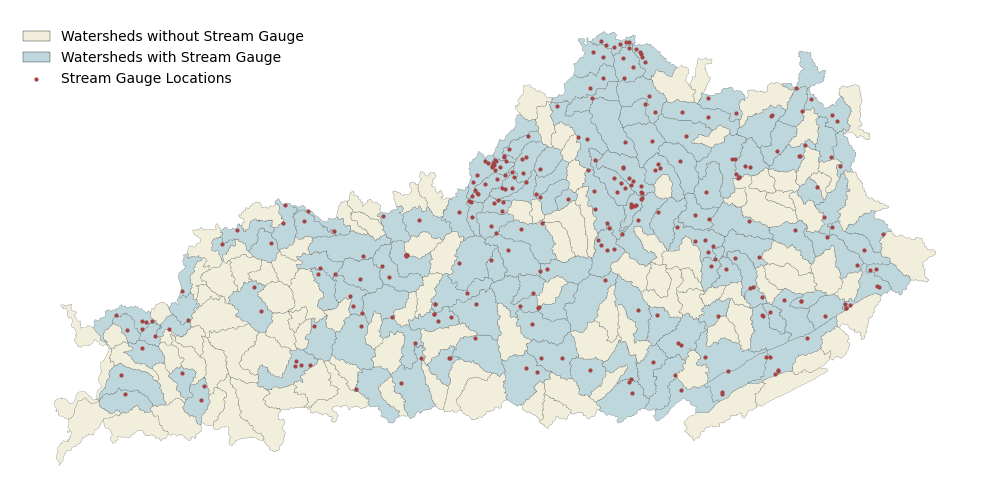

In [36]:
# plot watersheds (that intersect Kentucky only) and stream gauge locations...
fig, ax = plt.subplots(figsize=(10,7))

# define colormap for watershed polygons
watershed_colors = ListedColormap(['#F1EEDC', '#BED7DC'], 'watershed_colors')

# plot watershed polygons
gdf_watersheds.plot(column='gauge', ax=ax, cmap=watershed_colors, edgecolor='k', linewidth=0.1)

# plot stream gauge locations
gdf_gauges.plot(ax=ax, markersize=4, color='#A34343')

# create custom legend handles
legend_handles = [Patch(facecolor='#F1EEDC', edgecolor='k', linewidth=0.25, label='Watersheds without Stream Gauge'), 
                  Patch(facecolor='#BED7DC', edgecolor='k', linewidth=0.25, label='Watersheds with Stream Gauge'), 
                  plt.scatter([], [], s=4, c='#A34343', label='Stream Gauge Locations')]

# add legend with custom legend handles
ax.legend(handles=legend_handles, bbox_to_anchor=(0, 0.9), loc='center left', frameon=False)

ax.set_axis_off()
plt.tight_layout()
plt.show()

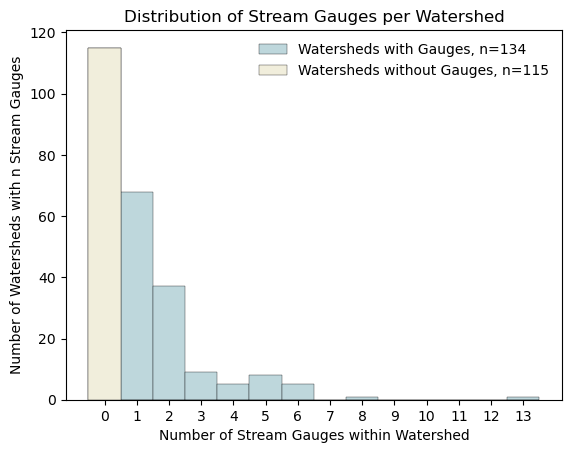

In [37]:
# histogram show stream gauge count for watersheds...
# get counts of watersheds with stream gauges
gauge_counts = gdf_gauges['huc10'].value_counts()

# add watersheds with no stream gauges...
for watershed in gdf_watersheds.loc[gdf_watersheds['gauge'] == 0, 'huc10']:
    gauge_counts.loc[watershed] = 0

# plot histogram of counts...
fig, ax = plt.subplots()

# define bins that align centered on bin number...
min_count = gauge_counts.min()
max_count = gauge_counts.max()
bin_edges = np.arange(min_count - 0.5, max_count + 1.5, 1)

# plot histogram for watersheds with stream gauges
ax.hist(gauge_counts, bins=bin_edges, color='#BED7DC', edgecolor='k', linewidth=0.25, 
        label=f'Watersheds with Gauges, n={(gauge_counts.values>0).sum()}')

# plot histogram for watersheds without stream gauges
ax.hist([0], bins=bin_edges, weights=[(gdf_watersheds['gauge']==0).sum()], color='#F1EEDC', edgecolor='k', linewidth=0.25, 
        label=f'Watersheds without Gauges, n={(gauge_counts.values==0).sum()}')

# customize plot...
ax.legend(frameon=False)
ax.grid(False)
ax.set_xticks(range(min_count, max_count + 1))
ax.set_xlabel('Number of Stream Gauges within Watershed')
ax.set_ylabel('Number of Watersheds with n Stream Gauges')
ax.set_title('Distribution of Stream Gauges per Watershed')

plt.show()

## Plot all data by Watershed

In [38]:
def read_and_prepare_data(file_path, columns_to_drop):
    """Read CSV file, drop specified columns, and set 'datetime' as index."""
    df = pd.read_csv(file_path, parse_dates=['datetime'])
    df.drop(columns=df.columns[columns_to_drop], inplace=True)
    df.set_index('datetime', inplace=True)
    return df

def calculate_ci(df, alpha):
    """Calculate moving average and confidence interval envelope."""
    rolling = df.iloc[:, 0].rolling(window='90D', min_periods=10)
    df['ma'] = rolling.mean()
    df['std'] = rolling.std()
    df['df'] = rolling.count() - 1
    df['t_critical'] = df['df'].apply(lambda x: t.ppf(1 - alpha/2, x) if x > 0 else np.nan)
    df['moe'] = df['t_critical'] * df['std'] / np.sqrt(rolling.count())
    df['upperci'] = df['ma'] + df['moe']
    df['lowerci'] = df['ma'] - df['moe']
    return df

def process_gauge_data(gauge, data_type, columns_to_drop=[0,1,3,5], alpha=0.05):
    """Process gauge data based on type ('gh' or 'sf')."""
    if data_type == 'gauge height':
        file_path = glob.glob(f'../Data/stream_gauges/gauge_height/{gauge}*.csv')[0]
    else:
        file_path = glob.glob(f'../Data/stream_gauges/streamflow/{gauge}*.csv')[0]
    df = read_and_prepare_data(file_path, columns_to_drop)
    df = calculate_ci(df, alpha)
    return df

def create_subplot_axes(nrows):
    """Dynamically create subplot axes based on the number of rows."""
    fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, figsize=(7, 4*nrows))
    if nrows == 1:
        axes = [axes]  # Ensure axes is always a list for consistency
    return fig, axes

In [ ]:
    ax[0].legend(frameon=False)
    ax[0].tick_params(labelbottom=False)
    ax[0].set_ylim(bottom=0)
    ax[0].set_ylabel('Flood Stage (ft)')

    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Date')
    ax[1].set_ylim(bottom=0)
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')
    ax[1].set_ylabel('Discharge (m$^3$/s)')

    plt.subplots_adjust(hspace=0)
    plt.suptitle(f'{watershed_name}\n(HUC10 ID={watershed})', y=0.93)
    plt.show()

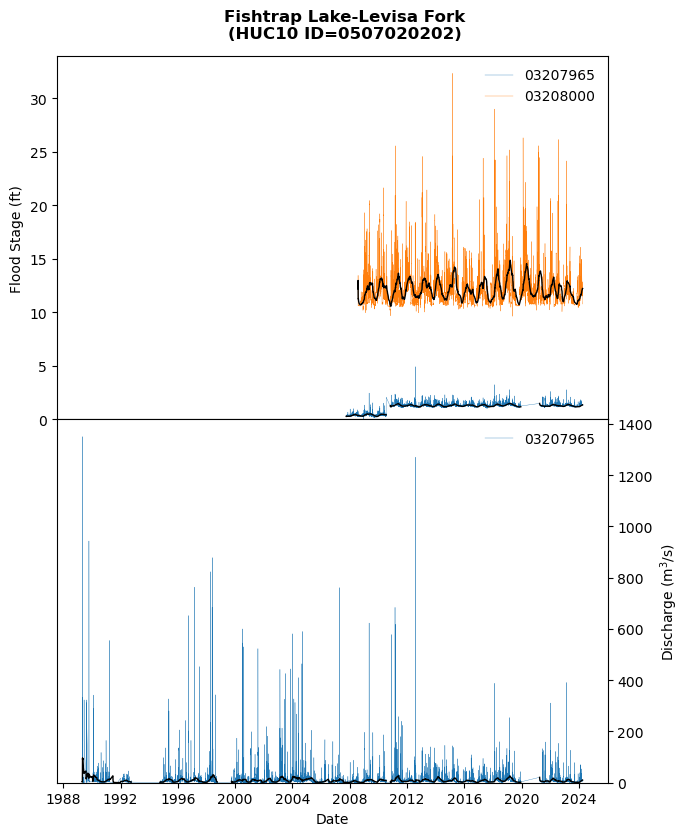

In [46]:
# get array of unique watershed id's with stream gauges
watersheds_with_gauges = gdf_gauges['huc10'].unique()

# iterate through watersheds with stream gauges...
for watershed in watersheds_with_gauges:

    # get dataframe of all stream gauges within watershed
    watershed_gauges = gdf_gauges.loc[gdf_gauges['huc10'] == watershed]

    # get name of watershed (for plotting)
    watershed_name = gdf_watersheds.loc[gdf_watersheds['huc10'] == watershed, 'name'].values[0]

    # check data availability...
    has_gh = any(watershed_gauges['gh'] == 1)     # gauge height
    has_sf = any(watershed_gauges['sf'] == 1)     # streamflow

    # define number of subplot rows based on data availability
    nrows = sum([has_gh, has_sf])

    # handle gauges with no data (shouldn't be any with preprocessing)
    if nrows == 0:
        continue

    # plot...
    fig, ax = create_subplot_axes(nrows)

    # if only one data type make ax object iterable
    if nrows == 1:
        ax = [ax]

    # define significance level for confidence interval
    alpha=0.001

    # gauge height data...
    if has_gh:

        # subset watershed dataframe for gauge height data only
        gauge_height_gauges = watershed_gauges[watershed_gauges['gh'] == 1]

        # iterate through all stream gauges with gauge height data...
        for index, row in gauge_height_gauges.iterrows():

            # call custom functions to process data, calculate moving average and confidence interval, return dataframe
            df_gh = process_gauge_data(row['site_no'], 'gauge height', alpha=alpha)

            # plot raw data
            ax[0].plot(df_gh.index, df_gh.iloc[:,0], linewidth=0.25, label=f"{row['site_no']}")

            # plot upper confidence interval
            ax[0].plot(df_gh.index, df_gh['upperci'], linewidth=1, color='k')

        ax[0].legend(frameon=False)
        ax[0].set_ylim(bottom=0)
        ax[0].set_ylabel('Flood Stage (ft)')

    # streamflow data...
    if has_sf:
        
        # determine the correct index for streamflow data (for correct subplot axes)
        sf_index = 1 if has_gh else 0

        # subset dataframe
        streamflow_gauges = watershed_gauges[watershed_gauges['sf'] == 1]

        # iterate through all stream gauges with streamflow data
        for index, row in streamflow_gauges.iterrows():

            # call custom functions to process data, calculate moving average and confidence interval, return dataframe
            df_sf = process_gauge_data(row['site_no'], 'streamflow', alpha=alpha)

            # plot raw data
            ax[sf_index].plot(df_sf.index, df_sf.iloc[:,0], linewidth=0.25, label=f"{row['site_no']}")

            # plot upper confidence interval
            ax[sf_index].plot(df_sf.index, df_sf['upperci'], linewidth=1, color='k')

        ax[sf_index].legend(frameon=False)
        ax[sf_index].set_ylim(bottom=0)
        ax[sf_index].set_ylabel('Discharge (m$^3$/s)')

    # set common x-label for the last subplot
    ax[-1].set_xlabel('Date')
    
    if has_gh and has_sf:
        ax[0].tick_params(labelbottom=False)
        ax[sf_index].yaxis.tick_right()
        ax[sf_index].yaxis.set_label_position('right')
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.suptitle(f'{watershed_name}\n(HUC10 ID={watershed})', y=1.04, weight='bold')
    plt.show()
        
    break

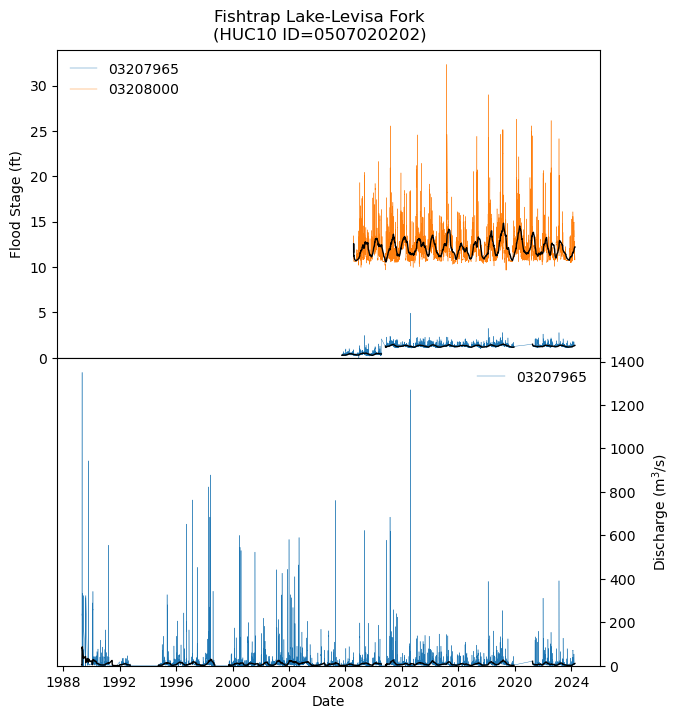

In [209]:
watersheds_with_gauges = gdf_gauges['huc10'].unique()

for watershed in watersheds_with_gauges:
        
    watershed_gauges = gdf_gauges.loc[gdf_gauges['huc10'] == watershed]
    watershed_name = gdf_watersheds.loc[gdf_watersheds['huc10'] == watershed, 'name'].values[0]

    # check data availability
    has_gh = any(watershed_gauges['gh'] == 1)
    has_sf = any(watershed_gauges['sf'] == 1)

    # define number of subplot rows based on data availability
    nrows = sum([has_gh, has_sf])

    # handle gauges with no data (shouldn't be any with preprocessing)
    if nrows == 0:
        continue

    # define subplots based on nrows count above
    fig, ax = plt.subplots(nrows=nrows, ncols=1, sharex=True, figsize=(7, 4*nrows))

    # iterate through watershed_gauges...
    for index, row in watershed_gauges.iterrows():

        # specific gauge
        gauge = row['site_no']

        # gauge height data...
        if row['gh'] == 1:
            
            # path to data file
            gaugeheight_path = glob.glob(f'../Data/stream_gauges/gauge_height/{gauge}*.csv')[0]

            # read data as dataframe, with datetime dtype
            df_gh = pd.read_csv(gaugeheight_path, parse_dates=['datetime'])

            df_gh.drop(columns=df_gh.columns[[0,1,3,5]], inplace=True)

            # plot gauge height onto subplot
            ax[0].plot(df_gh['datetime'], df_gh.iloc[:,1], linewidth=0.3, label=f'{gauge}')

            # moving average and confidence interval...
            df_gh.set_index('datetime', inplace=True)
            rolling = df_gh.iloc[:,0].rolling(window='90D', min_periods=10)
            df_gh['ma'] = rolling.mean()
            df_gh['std'] = rolling.std()
            
            alpha = 0.05
            df_gh['df'] = rolling.count() - 1
            df_gh['t_critical'] = df_gh['df'].apply(lambda x: t.ppf(1 - alpha/2, x) if x > 0 else np.nan)
            df_gh['moe'] = df_gh['t_critical'] * df_gh['std'] / np.sqrt(rolling.count())
            df_gh['upperci'] = df_gh['ma'] + df_gh['moe']
            # df_gh['lowerci'] = df_gh['ma'] - df_gh['moe']

            ax[0].plot(df_gh.index, df_gh['upperci'], linewidth=1, color='k')
            # ax[0].fill_between(df_gh.index, df_gh['upperci'], df_gh['lowerci'], alpha=0.2, where=~df_gh['moe'].isna())
            

        # streamflow data...
        if row['sf'] == 1:
            streamflow_path = glob.glob(f'../Data/stream_gauges/Streamflow/{gauge}*.csv')[0]
            df_sf = pd.read_csv(streamflow_path, parse_dates=['datetime'])
            df_sf.drop(columns=df_sf.columns[[0,1,3,5]], inplace=True)
            ax[1].plot(df_sf['datetime'], df_sf.iloc[:,1], linewidth=0.3, label=f'{gauge}')

            # moving average and confidence interval...
            df_sf.set_index('datetime', inplace=True)
            rolling = df_sf.iloc[:,0].rolling(window='90D', min_periods=10)
            df_sf['ma'] = rolling.mean()
            df_sf['std'] = rolling.std()
            
            alpha = 0.05
            df_sf['df'] = rolling.count() - 1
            df_sf['t_critical'] = df_sf['df'].apply(lambda x: t.ppf(1 - alpha/2, x) if x > 0 else np.nan)
            df_sf['moe'] = df_sf['t_critical'] * df_sf['std'] / np.sqrt(rolling.count())
            df_sf['upperci'] = df_sf['ma'] + df_sf['moe']
            # df_gh['lowerci'] = df_gh['ma'] - df_gh['moe']

            ax[1].plot(df_sf.index, df_sf['upperci'], linewidth=1, color='k')

    # if nrows == 1:

    # if nrows > 1:
    ax[0].legend(frameon=False)
    ax[0].tick_params(labelbottom=False)
    ax[0].set_ylim(bottom=0)
    ax[0].set_ylabel('Flood Stage (ft)')

    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Date')
    ax[1].set_ylim(bottom=0)
    ax[1].yaxis.tick_right()
    ax[1].yaxis.set_label_position('right')
    ax[1].set_ylabel('Discharge (m$^3$/s)')

    plt.subplots_adjust(hspace=0)
    plt.suptitle(f'{watershed_name}\n(HUC10 ID={watershed})', y=0.93)
    plt.show()

    break
    

# Identify Elevated Stream Flow Events

# Calculate Elevated Stream Flow Frequency